In [1]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

newdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
newdemo = pickle.load(open(f'{newdir}/demographics.pkl', 'rb'))

newfc = []
age = []
sex = []
race = []

for sub in newdemo['age_at_cnb']:
    for task in ['rest', 'nback', 'emoid']:
        f = f'{newdir}/fc/{sub}_task-{task}_fc.npy'
        if not Path(f).exists():
            continue
        if sub not in newdemo['Race'] or newdemo['Race'][sub] not in ['AA', 'EA']:
            continue
        p = np.load(f)
        a = newdemo['age_at_cnb'][sub]
        s = newdemo['Sex'][sub] == 'M'
        r = newdemo['Race'][sub] == 'AA'
        newfc.append(p)
        age.append(a)
        sex.append(s)
        race.append(r)
        
newfc = np.stack(newfc)
age = np.array(age)
sex = np.array(sex)
race = np.array(race)

print(age.shape)
print(np.mean(age))
print(np.mean(sex))
print(np.mean(race))
print(newfc.shape)

(3849,)
14.398285268901013
0.473629514159522
0.4811639386853728
(3849, 34716)


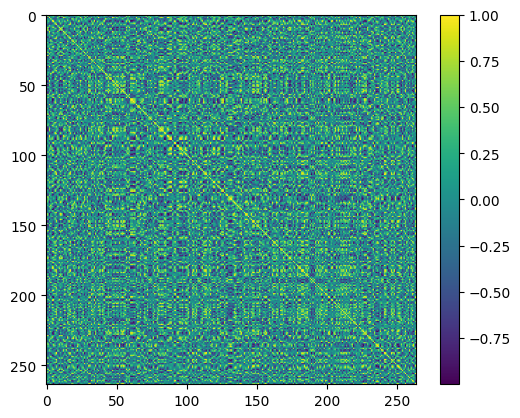

In [209]:
# Angle estimate

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

pi = 3.14
pi2 = 2*pi

def tonp(t):
    return t.detach().cpu().numpy()

class AngleBasis(nn.Module):
    def __init__(self, mixn):
        super(AngleBasis, self).__init__()
        self.mixn = mixn
        self.thetas = nn.Parameter((pi2*torch.rand(self.mixn,264)).float().cuda())
        self.jitter = nn.Parameter(torch.ones(self.mixn,264).float().cuda())
        
    def project(self):
        with torch.no_grad():
            self.thetas[self.thetas < 0] = pi2
            self.thetas[self.thetas > pi2] = 0
            self.jitter[self.jitter < 0] = 0
            self.jitter[self.jitter > 1] = 1
        
    def phases(self):
        t0 = self.thetas.unsqueeze(2)
        t1 = self.thetas.unsqueeze(1)
        return t0-t1
    
    def jit(self):
        j0 = self.jitter.unsqueeze(2)
        j1 = self.jitter.unsqueeze(1)
        return j0*j1
    
    def ps(self, jitter=True):
        t = self.phases()
        p = torch.cos(t)
        if jitter:
            j = self.jit()
            p = j*p
        return p
    
    def psum(self):
        return torch.mean(self.ps(), axis=0)
    
    def pvec(self):
        a,b = np.triu_indices(264,1)
        p = self.psum()
        return p[a,b]
    
basis = AngleBasis(2)
plt.imshow(tonp(basis.psum()))
plt.colorbar()
plt.show()

In [213]:
nepochs = 500
pperiod = 500

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def rmse(yhat, y):
    if isinstance(yhat, np.ndarray):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

x = fromnp(newfc[22])

min_loss = 10
sav = None

for _ in range(10):
    basis = AngleBasis(1)
    optim = torch.optim.Adam(basis.parameters(), lr=1e-2, weight_decay=0)

    for e in range(nepochs):
        optim.zero_grad()
        xhat = basis.pvec()
        loss = rmse(xhat, x)
        loss.backward()
        optim.step()
        basis.project()
        if e == nepochs-1 or e % pperiod == 1:
            print(f'{e} {float(loss)}')
            
    if loss < min_loss:
        print('Saving')
        min_loss = float(loss)
        sav = basis
        
print('Complete')

1 0.8241280317306519
499 0.1075303852558136
Saving
1 0.8219926953315735
499 0.12238460779190063
1 0.817575991153717
499 0.09395663440227509
Saving
1 0.8190487623214722
499 0.11445585638284683
1 0.8241837024688721
499 0.1263417899608612
1 0.8189627528190613
499 0.1331469714641571
1 0.8222505450248718
499 0.08513109385967255
Saving
1 0.8222658038139343
499 0.1298052817583084
1 0.8195641040802002
499 0.0915905013680458
1 0.8200646042823792
499 0.11464163661003113
Complete


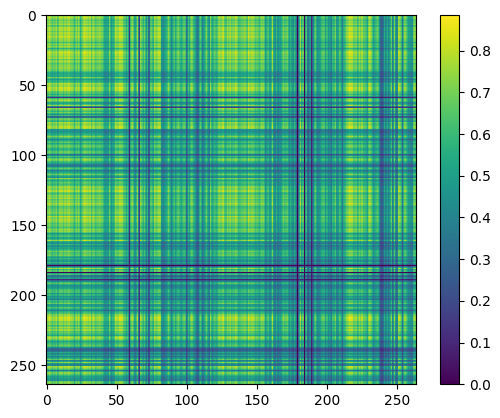

In [215]:
plt.imshow(remap(tonp(sav.jit()[0])))
plt.colorbar()
plt.show()

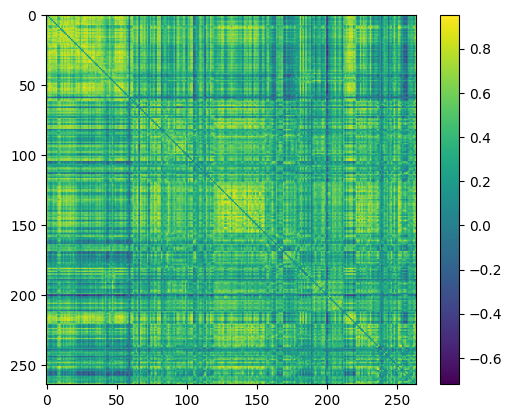

In [216]:
plt.imshow(remap(vec2mat(tonp(x))))
plt.colorbar()
plt.show()

In [16]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
